# Mount the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

import matplotlib.pyplot as plt
import numpy as np
import re

print(tf.__version__)

2.15.0


In [3]:
# Code to leverage TPU acceleration
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError as e:
    print("Error: ", e)
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Error:  Please provide a TPU Name to connect to.
Number of replicas: 1


# Parameters for Data Preprocessing and Model Training

In [4]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
OUTPUT_CHANNELS = 3
EPOCHS = 12
BATCH_SIZE = 2

# Read the data from the TFRecord files provided

In [5]:
FILE_PATH = "/content/drive/MyDrive/GAN"

In [6]:
def count_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [7]:
photo_filenames = tf.io.gfile.glob(str(FILE_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(photo_filenames))

monet_filenames = tf.io.gfile.glob(str(FILE_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monet_filenames))

monet_samples_num = count_items(monet_filenames)
photo_samples_num = count_items(photo_filenames)

Photo TFRecord Files: 20
Monet TFRecord Files: 5


In [8]:
def decode_image(i):
    i = tf.image.decode_jpeg(i, channels=CHANNELS)
    i = (tf.cast(i, tf.float32) / 127.5) - 1
    i = tf.reshape(i, [HEIGHT, WIDTH, CHANNELS])
    return i

def read_tfrecord(x):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    x = tf.io.parse_single_example(x, tfrecord_format)
    i = decode_image(x['image'])
    return i

In [9]:
def load_dataset(filenames, labeled=True, ordered=False):
    data1 = tf.data.TFRecordDataset(filenames)
    data1 = data1.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return data1

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=2):
    monet_data = load_dataset(monet_files)
    photo_data = load_dataset(photo_files)

    if repeat:
        monet_data = monet_data.repeat()
        photo_data = photo_data.repeat()
    if shuffle:
        monet_data = monet_data.shuffle(2048)
        photo_data = photo_data.shuffle(2048)

    monet_data = monet_data.batch(batch_size, drop_remainder=True)
    photo_data = photo_data.batch(batch_size, drop_remainder=True)
    monet_data = monet_data.cache()
    photo_data = photo_data.cache()
    monet_data = monet_data.prefetch(AUTOTUNE)
    photo_data = photo_data.prefetch(AUTOTUNE)

    gan_ds = tf.data.Dataset.zip((monet_data, photo_data))

    return gan_ds

In [10]:
monet_data = load_dataset(monet_filenames, labeled=True).batch(1)
photo_data = load_dataset(photo_filenames, labeled=True).batch(1)

In [11]:
monet_example = next(iter(monet_data))
photo_example = next(iter(photo_data))

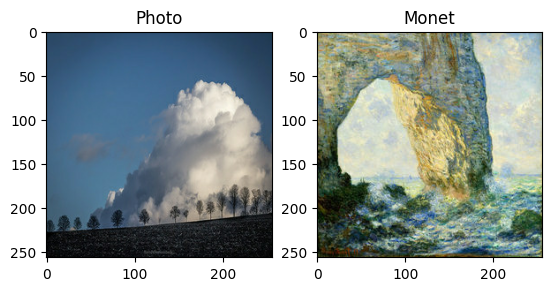

In [12]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(photo_example[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(monet_example[0] * 0.5 + 0.5)

# GAN Generator

In [13]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.GroupNormalization(groups=-1))
        #result.add(layers.LayerNormalization(groups=-1))

    result.add(layers.LeakyReLU())

    return result


In [14]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.GroupNormalization(groups=-1))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [15]:
def Generator():
    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

In [16]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = layers.GroupNormalization(groups=-1)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [17]:
with strategy.scope():
    # transforms Photos to look like Monet paintings
    monet_generator = Generator()
    # transforms Monet paintings to look like Photos
    photo_generator = Generator()

    # differentiates between real Monet paintings and generated Monet paintings
    monet_discriminator = Discriminator()
    # differentiates between real Photos and generated Photos
    photo_discriminator = Discriminator()

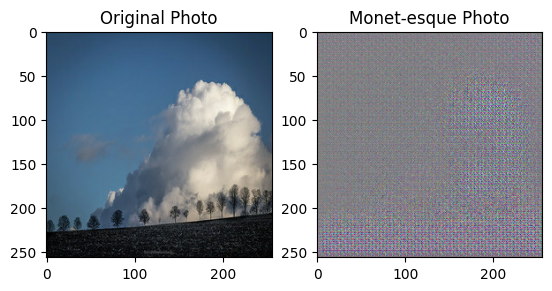

In [18]:
to_monet = monet_generator(photo_example)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(photo_example[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN model

In [19]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            self_monet = self.m_gen(real_monet, training=True)
            self_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, self_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, self_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

 # Define loss functions

In [20]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [21]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [22]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [23]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

In [24]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [25]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [26]:
history = cycle_gan_model.fit(
    get_gan_dataset(monet_filenames, photo_filenames, batch_size=BATCH_SIZE),
    steps_per_epoch=(max(monet_samples_num, photo_samples_num)//4),
    epochs=EPOCHS
).history

Epoch 1/12
1759/1759 [==============================] - 213s 88ms/step - monet_gen_loss: 3.4966 - photo_gen_loss: 3.5216 - monet_disc_loss: 0.6426 - photo_disc_loss: 0.6432
Epoch 2/12
1759/1759 [==============================] - 155s 88ms/step - monet_gen_loss: 2.7193 - photo_gen_loss: 2.8486 - monet_disc_loss: 0.6470 - photo_disc_loss: 0.6111
Epoch 3/12
1759/1759 [==============================] - 155s 88ms/step - monet_gen_loss: 2.5905 - photo_gen_loss: 2.7386 - monet_disc_loss: 0.6538 - photo_disc_loss: 0.6235
Epoch 4/12
1759/1759 [==============================] - 155s 88ms/step - monet_gen_loss: 2.5726 - photo_gen_loss: 2.6510 - monet_disc_loss: 0.6420 - photo_disc_loss: 0.6320
Epoch 5/12
1759/1759 [==============================] - 155s 88ms/step - monet_gen_loss: 2.5263 - photo_gen_loss: 2.6051 - monet_disc_loss: 0.6372 - photo_disc_loss: 0.6256
Epoch 6/12
1759/1759 [==============================] - 156s 88ms/step - monet_gen_loss: 2.5853 - photo_gen_loss: 2.6608 - monet_disc_l

# Visualize our Monet-esque photos

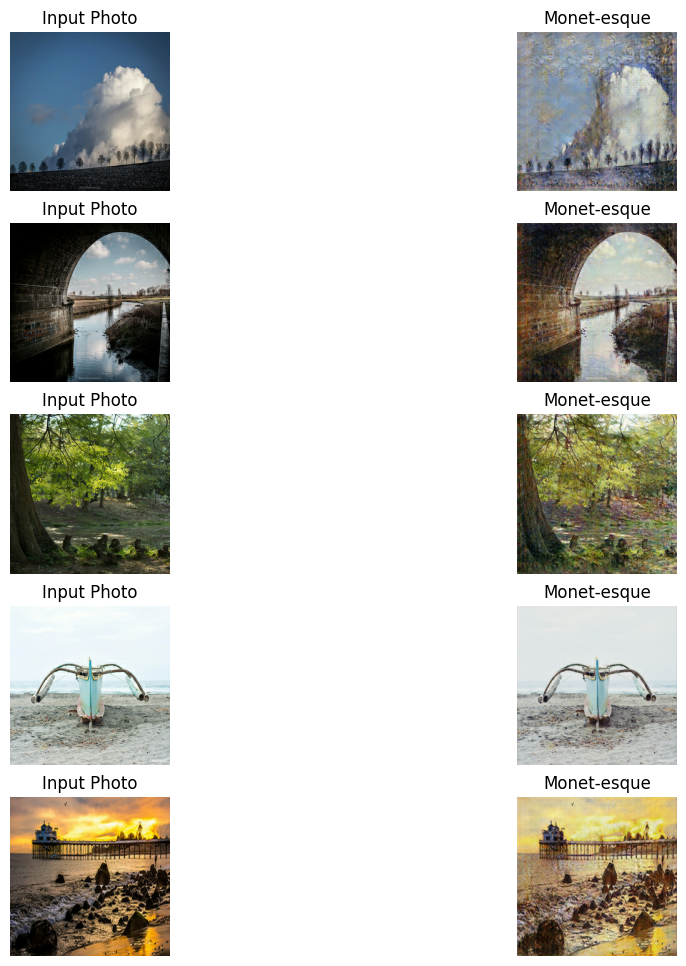

In [27]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_data.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create submission

In [28]:
import PIL
! mkdir /content/drive/MyDrive/GAN/images

mkdir: cannot create directory ‘/content/drive/MyDrive/GAN/images’: File exists


In [29]:
i = 1
for img in photo_data:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/content/drive/MyDrive/GAN/images/" + str(i) + ".jpg")
    i += 1

In [31]:
import shutil
shutil.make_archive("/content/drive/MyDrive/GAN/images", 'zip', "/content/drive/MyDrive/GAN/images")

'/content/drive/MyDrive/GAN/images.zip'